The function `plotTMB` includes code originally developed by Yudou He (Alexandrov Lab), licensed under the BSD 2-Clause License. See `THIRD_PARTY_NOTICES.md` for details.

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def prepend(list, str):
    str += "{0}"
    list = [str.format(i) for i in list]
    return list


def plotTMB(
    inputDF,
    scale,
    Yrange="adapt",
    cutoff=0,
    output="TMB_plot.png",
    redbar="median",
    yaxis="Somatic Mutations per Megabase",
    ascend=True,
    leftm=1,
    rightm=0.3,
    topm=1.4,
    bottomm=1,
    filterline=True,
    output_df="final_dataframe.csv",
):
    # check if scale input is correct format: int, 'custom', 'genome', or 'exome'
    if isinstance(scale, int) or scale == "custom":
        scale = scale
    elif scale == "genome":
        scale = 2800
    elif scale == "exome":
        scale = 55
    else:
        print(
            'Please input valid scale values: "exome", "genome", a list of integers for each row in the input dataframe, or a numeric value'
        )
        return

    # label columns
    if scale == "custom":
        inputDF.columns = ["Types", "Mut_burden", "Scale"]
    else:
        inputDF.columns = ["Types", "Mut_burden"]

    # filter for cutoff
    df = inputDF[inputDF["Mut_burden"] > cutoff]

    # generate log10 column
    if isinstance(scale, int):
        df["log10BURDENpMB"] = df.apply(
            lambda row: np.log10(row.Mut_burden / scale), axis=1
        )
    elif scale == "custom":
        df["log10BURDENpMB"] = df.apply(
            lambda row: np.log10(row.Mut_burden / row.Scale), axis=1
        )
    else:
        print("scale was not an int or list: ")
        print(scale)
        return

    # Save the final dataframe to the specified file
    df.to_csv(output_df, index=False)
    print(f"Final dataframe saved to {output_df}")

    # group by the type
    groups = df.groupby(["Types"])

    # calculate red bar location
    if redbar == "mean":
        redbars = groups.mean()["log10BURDENpMB"].sort_values(ascending=ascend)
        names = groups.mean()["log10BURDENpMB"].sort_values(ascending=ascend).index
    elif redbar == "median":
        redbars = groups.median()["log10BURDENpMB"].sort_values(ascending=ascend)
        names = groups.median()["log10BURDENpMB"].sort_values(ascending=ascend).index
    else:
        print("ERROR: redbar parameter must be either mean or median")
        return

    counts = groups.count()["log10BURDENpMB"][names]
    ngroups = groups.ngroups

    # second row of bottom label
    input_groups = inputDF.groupby(["Types"])
    input_counts = input_groups.count()["Mut_burden"][names]

    list1 = counts.to_list()
    list2 = input_counts.to_list()

    if filterline:
        different = any(list2[i] != count for i, count in enumerate(list1))
        if not different:
            filterline = False

    new_labels = None
    if filterline:
        str1 = ""
        list3 = prepend(list1, str1)
        str2 = "\n"
        list4 = prepend(list2, str2)
        result = [None] * (len(list3) + len(list4))
        result[::2] = list3
        result[1::2] = list4
        tick_labels = result
        new_labels = ["".join(x) for x in zip(tick_labels[0::2], tick_labels[1::2])]
    else:
        new_labels = list1

    # calculate y range
    if Yrange == "adapt":
        ymax = math.ceil(df["log10BURDENpMB"].max())
        ymin = math.floor(df["log10BURDENpMB"].min())
    elif Yrange == "cancer":
        ymax = 3
        ymin = -3
    elif type(Yrange) == list:
        ymax = int(math.log10(Yrange[1]))
        ymin = int(math.log10(Yrange[0]))
    else:
        print(
            'ERROR:Please input valid scale values: "adapt", "cancer" or a list of two power of 10 numbers'
        )
        return

    # plotting
    if ngroups < 7:
        rightm += 0.4 * (7 - ngroups)
    if len(names[0]) > 13:
        leftm += 0.09 * (len(names[0]) - 13)
        topm += 0.080 * (len(names[0]) - 13)

    fig_width = leftm + rightm + 0.4 * ngroups
    fig_length = topm + bottomm + (ymax - ymin) * 0.7
    fig, ax = plt.subplots(figsize=(fig_width, fig_length))

    plt.xlim(0, 2 * ngroups)
    plt.ylim(ymin, ymax)

    yticks_loc = range(ymin, ymax + 1, 1)
    plt.yticks(yticks_loc, list(map((lambda x: 10**x), list(yticks_loc))))
    plt.xticks(np.arange(1, 2 * ngroups + 1, step=2), new_labels)
    plt.tick_params(axis="both", which="both", length=0)

    plt.hlines(
        yticks_loc,
        0,
        2 * ngroups,
        colors="black",
        linestyles="dashed",
        linewidth=0.5,
        zorder=1,
    )

    for i in range(0, ngroups, 2):
        greystart = [(i) * 2, ymin]
        rectangle = mpatches.Rectangle(
            greystart, 2, ymax - ymin, color="lightgrey", zorder=0
        )
        ax.add_patch(rectangle)

    for i in range(0, ngroups):
        X_start = i * 2 + 0.2
        X_end = i * 2 + 2 - 0.2
        y_values = (
            groups.get_group(names[i])["log10BURDENpMB"]
            .sort_values(ascending=True)
            .values.tolist()
        )
        x_values = list(np.linspace(start=X_start, stop=X_end, num=counts[i]))
        plt.scatter(x_values, y_values, color="black", s=1.5)
        plt.hlines(redbars[i], X_start, X_end, colors="red", zorder=2)

    plt.ylabel(yaxis)
    plt.savefig(output)

In [ ]:
import os


def process_maf_files(file_paths, cancer_type_mapping):
    """
    Processes a list of MAF files to extract cancer type and mutation counts per sample.

    Args:
        file_paths (list of str): List of file paths to MAF files.
        cancer_type_mapping (dict): Mapping of study numbers to cancer types.

    Returns:
        pd.DataFrame: DataFrame with columns 'Cancer_Type', 'Tumor_Sample_Barcode', and 'Mutation_Count'.
    """
    results = []

    for file_path in file_paths:
        # Extract study identifier from the file name
        study_id = os.path.basename(file_path).split("_")[5]
        print(study_id)

        # Map to cancer type
        cancer_type = cancer_type_mapping.get(study_id, "Unknown")

        # Read the MAF file
        maf_data = pd.read_csv(file_path, sep="\t", low_memory=False)

        # Count mutations for each Tumor_Sample_Barcode
        mutation_counts = maf_data["Tumor_Sample_Barcode"].value_counts()

        # Append results as tuples
        for sample, count in mutation_counts.items():
            results.append((cancer_type, sample, count))

    # Create a DataFrame from the results
    df = pd.DataFrame(
        results, columns=["Cancer_Type", "Tumor_Sample_Barcode", "Mutation_Count"]
    )
    return df

In [ ]:
from pathlib import Path

maf_dir = Path("./data")
maf_files = maf_dir.glob("keep_vaf_size_filt_matched_*.maf")
maf_files = [str(file) for file in maf_files]

maf_files

['data/keep_vaf_size_filt_matched_7040_3064.finalised.maf',
 'data/keep_vaf_size_filt_matched_6864_2965.finalised.maf',
 'data/keep_vaf_size_filt_matched_6555_2711.finalised.maf',
 'data/keep_vaf_size_filt_matched_6841_2964.finalised.maf',
 'data/keep_vaf_size_filt_matched_7098_3140.finalised.maf',
 'data/keep_vaf_size_filt_matched_6711_2820_2025_02_10.hotspot_mutations.maf',
 'data/keep_vaf_size_filt_matched_6973_2987.finalised.maf',
 'data/keep_vaf_size_filt_matched_6945_3142_2025_02_10.hotspot_mutations.maf',
 'data/keep_vaf_size_filt_matched_6712_2822_2025_02_10.hotspot_mutations.maf',
 'data/keep_vaf_size_filt_matched_6713_2821.finalised.maf',
 'data/keep_vaf_size_filt_matched_6982_3135.finalised.maf',
 'data/keep_vaf_size_filt_matched_6990_3065.finalised.maf',
 'data/keep_vaf_size_filt_matched_7097_3073.finalised.maf']

In [ ]:
cancer_type_mapping = {
    "6555": "LUCA",
    "6711": "cSCC",
    "6712": "oSCC",
    "6713": "cMCT",
    "6841": "MEN",
    "6864": "PANC",
    "6945": "CHOL",
    "6973": "OSA",
    "6982": "LYM",
    "6990": "MAM",
    "7040": "BCC",
    "7097": "CRC",
    "7098": "GLIO",
}

tmb_df = process_maf_files(maf_files, cancer_type_mapping)
tmb_df_drop = tmb_df.drop(columns="Tumor_Sample_Barcode")

7040
6864
6555
6841
7098
6711
6973
6945
6712
6713
6982
6990
7097


Final dataframe saved to final_dataframe.csv


/tmp/ipykernel_2091124/3060710073.py:136: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  y_values = groups.get_group(names[i])["log10BURDENpMB"].sort_values(ascending=True).values.tolist()
/tmp/ipykernel_2091124/3060710073.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_values = list(np.linspace(start=X_start, stop=X_end, num=counts[i]))
/tmp/ipykernel_2091124/3060710073.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.hlines(redbars[i], X_start, X_en

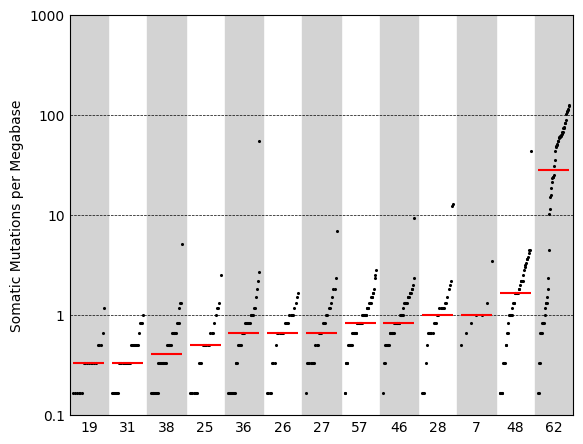

In [6]:
plotTMB(tmb_df_drop, scale=6, Yrange="adapt", cutoff=0, output="TMB_plot.pdf")

In [ ]:
# 1. List of the 34 SBS7‐positive sample IDs:
sbs7_positive = [
    "CATD0119a",
    "CATD0120a",
    "CATD0122a",
    "CATD0123a",
    "CATD0128a",
    "CATD0132a",
    "CATD0632c",
    "CATD0653a",
    "CATD187a",
    "CATD243a",
    "CATD244a",
    "CATD245a",
    "CATD246a",
    "CATD247a",
    "CATD248a",
    "CATD250a",
    "CATD251a",
    "CATD252a",
    "CATD253a",
    "CATD255a",
    "CATD256a",
    "CATD260a",
    "CATD262a",
    "CATD263a",
    "CATD264a",
    "CATD265a",
    "CATD268a",
    "CATD269a",
    "CATD272a",
    "CATD273a",
    "CATD274a",
    "CATD276a",
    "CATD278a",
    "CATD282a",
]

# 2. Flag each row for SBS7 presence
tmb_df["SBS7_positive"] = tmb_df["Tumor_Sample_Barcode"].isin(sbs7_positive)

# 3. Subset to the cSCC cohort
cSCC_df = tmb_df[tmb_df["Cancer_Type"] == "cSCC"].copy()

# 4. Compute TMB per Mb
scale_mb = 6
cSCC_df["TMB_perMb"] = cSCC_df["Mutation_Count"] / scale_mb

# 5. Calculate medians in the two groups
median_pos = cSCC_df.loc[cSCC_df["SBS7_positive"], "TMB_perMb"].median()
median_neg = cSCC_df.loc[~cSCC_df["SBS7_positive"], "TMB_perMb"].median()

print(f"Median TMB in SBS7-positive cSCC samples: {median_pos:.2f} mutations/Mb")
print(f"Median TMB in SBS7-negative cSCC samples: {median_neg:.2f} mutations/Mb")

Median TMB in SBS7-positive cSCC samples: 62.33 mutations/Mb
Median TMB in SBS7-negative cSCC samples: 1.25 mutations/Mb
